In [1]:
from posteriordb import PosteriorDatabase

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, vmap, jit
import jax.numpy as jnp
import jax

import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer.inspect import render_model

from kernels import ARWMH, ARWMHAdaptState, ARWMHState, SA, NUTS, ASSS, ASSSAdaptState
from utils.evaluation import wasserstein_1d, wasserstein_dist11_p
from utils.lipschitz import compute_wasserstein_contraction, compute_kernel_distance

In [2]:
svg_dir = "../img/svg/"

# 1. Univariate distribution

In [3]:
normal_dist = dist.Normal(0, 1)
potential_fn = lambda x: -1 *normal_dist.log_prob(x)

kernel_normal = ARWMH(potential_fn=potential_fn)
kernel_sa_normal = SA(potential_fn=potential_fn)
kernel_sss_normal = ASSS(potential_fn=potential_fn)
kernel_nuts_normal = NUTS(potential_fn=potential_fn)

In [4]:
def get_adapt_state(scale):
    return ASSSAdaptState(
        loc=jnp.array([0.0]),
        scale=scale,
    )
    # return ARWMHAdaptState(
    #     mean=jnp.array([0.0]),
    #     covariance=cov_matrix,
    #     log_step_size=jnp.array(0)
    # )


In [5]:
rng_key = random.PRNGKey(0)

# k1, k2 = random.split(rng_key)
# s1 = sample_adapt_state(k1)
# s2 = sample_neigbour(k2, s1, eps=0.1)
# s3 = sample_neigbour(k2, s1, eps=1)

s1 = get_adapt_state(jnp.array([[1.]]))
s2 = get_adapt_state(jnp.array([[1e-1]]))
s3 = get_adapt_state(jnp.array([[1e1]]))


# sample_dist1 = dist.MultivariateNormal(loc=s1.mean, covariance_matrix=jnp.exp(s1.log_step_size)*s1.covariance)
# sample_dist2 = dist.MultivariateNormal(loc=s2.mean, covariance_matrix=jnp.exp(s2.log_step_size)*s2.covariance)
# sample_dist3 = dist.MultivariateNormal(loc=s3.mean, covariance_matrix=jnp.exp(s3.log_step_size)*s3.covariance)

# state_dist(s1, s2)

In [6]:
s1, s2, s3

(ASSSAdaptState(loc=Array([0.], dtype=float32), scale=Array([[1.]], dtype=float32)),
 ASSSAdaptState(loc=Array([0.], dtype=float32), scale=Array([[0.1]], dtype=float32)),
 ASSSAdaptState(loc=Array([0.], dtype=float32), scale=Array([[10.]], dtype=float32)))

In [7]:
init_params = jnp.array(0.0)
# sa_state = kernel_sa_normal.get_init_adapt_state(rng_key, init_params)
sss_state = kernel_sss_normal.get_init_adapt_state(rng_key, init_params)
nuts_state = kernel_nuts_normal.get_init_adapt_state(rng_key, init_params)

In [8]:
x_dist = jnp.arange(-10, 10, .002)
# plt.hist(mcmc.get_samples(), bins=50, density=True, label="samples")

# plt.plot(x_dist, jnp.exp(normal_dist.log_prob(x_dist)), color="green", label=r"target $\pi$")

plt.plot(x_dist, jnp.exp(vmap(sample_dist2.log_prob)(x_dist)), color='orange', label=r"$\sigma^2 = 0.1$")
plt.plot(x_dist, jnp.exp(vmap(sample_dist1.log_prob)(x_dist)), color='blue', label=r"$\sigma^2 = 1$")
plt.plot(x_dist, jnp.exp(vmap(sample_dist3.log_prob)(x_dist)), color='red', label=r"$\sigma^2 = 10$")


plt.ylabel("density")
plt.xlabel("$x$")
plt.legend()
# plt.savefig(svg_dir + "univariate-normal.svg", format="svg")

NameError: name 'sample_dist2' is not defined

## 1.2. Sampling from $P(x, \cdot)$

In [9]:
rng_key = random.PRNGKey(0)
x = jnp.arange(-10, 10, 0.1)

In [24]:
%%time 

N = 100000

P1x = kernel_sss_normal.sample_Pnx(rng_key, x, s1, n=2, n_samples=N)
# P2x = sample_Px(rng_key, kernel, X, s2, N).squeeze()
# P3x = sample_Px(rng_key, kernel, X, s3, N).squeeze()

print(P1x.mean())

6.3516294e-05
CPU times: user 2min 21s, sys: 2.83 s, total: 2min 24s
Wall time: 47.6 s


In [25]:
P1x_mean = P1x.mean(axis=1) 
P1x_lower = jnp.quantile(P1x, 0.05, axis=1)
P1x_upper = jnp.quantile(P1x, 0.95, axis=1)

# dP2x = P2x - X
# dP2x_mean = dP2x.mean(axis=1)
# dP2x_acc_mean = dP1x.mean(axis=1, where=(dP2x != 0.0))
# P2x_lower = jnp.quantile(dP2x, 0.05, axis=1)
# P2x_upper = jnp.quantile(dP2x, 0.95, axis=1)
# # P2x_lower, P2x_upper = hpdi(dP2x , prob=0.99, axis=1).reshape(2, -1)

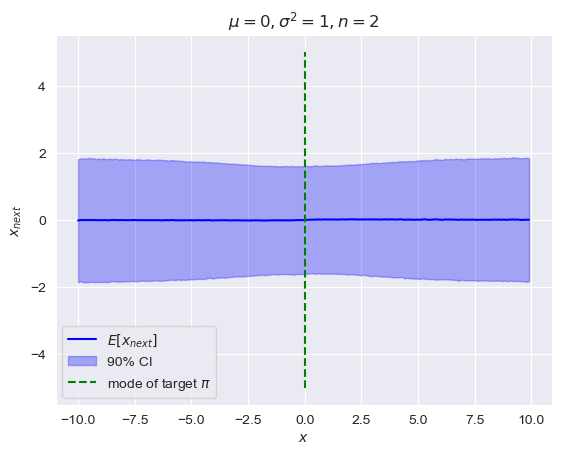

In [26]:
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\mu=0, \sigma^2=1, n=2$")

ax1.plot(x, P1x_mean, color='blue', label="$E[x_{next}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
# ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
# ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = 0$")
ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{next}$")
ax1.set_xlabel("$x$")
ax1.legend(loc="lower left")

# plt.savefig(svg_dir + "asss-univariate-x-step-cov1-n2.svg", format="svg")

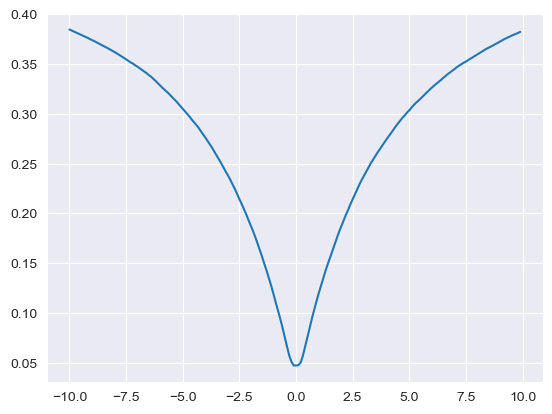

In [54]:
plt.plot(x, jnp.mean(dP1x == 0.0, axis=1))

In [ ]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)


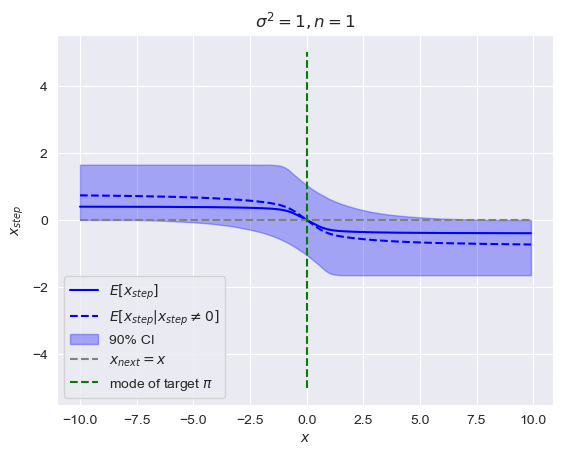

In [71]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=1$")

ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
# ax2.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")

plt.savefig(svg_dir + "univariate-x-step-cov1-n1.svg", format="svg")

In [14]:
%%time 

N = 10000
n = 5

P1x = kernel_normal.sample_Pnx(rng_key, X, s1, n, N).squeeze()
# P2x = sample_Pnx(rng_key, kernel, X, s2, n, N).squeeze()

NameError: name 'X' is not defined

In [60]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

# dP2x = P2x - X
# dP2x_mean = dP2x.mean(axis=1)
# dP2x_acc_mean = dP1x.mean(axis=1, where=(dP2x != 0.0))
# P2x_lower = jnp.quantile(dP2x, 0.05, axis=1)
# P2x_upper = jnp.quantile(dP2x, 0.95, axis=1)
# P2x_lower, P2x_upper = hpdi(dP2x , prob=0.99, axis=1).reshape(2, -1)

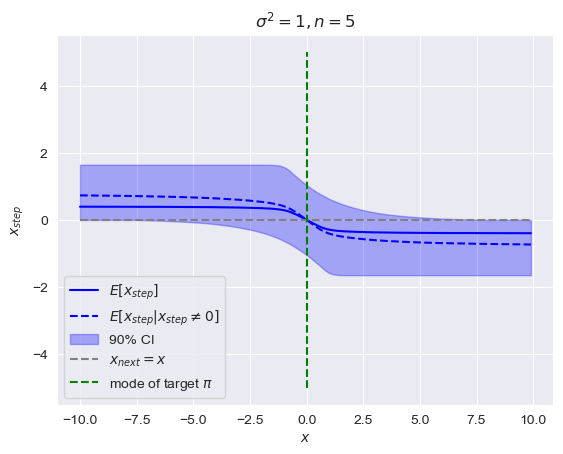

In [72]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=5$")
ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2^5$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2^5$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
# ax2.vlines(0, -10, 10, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")
plt.savefig(svg_dir + "univariate-x-step-cov1-n5.svg", format="svg")

## 1.3. Invariance Property

In [21]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = normal_dist.sample(ks, sample_shape=(100000,))

P1pi = kernel_sss_normal.sample_Pnx(k1, dist_samples, s1, n_samples=1).flatten()
# P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1000).flatten()

CPU times: user 1.25 s, sys: 77.2 ms, total: 1.33 s
Wall time: 653 ms


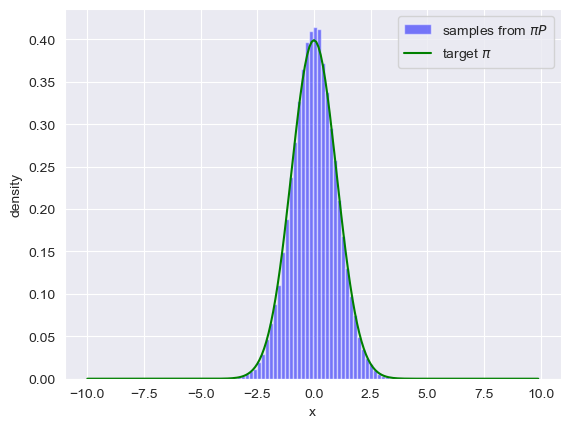

In [24]:
plt.hist(P1pi, bins=50, density=True, alpha=0.5, color="blue", label=r"samples from $\pi P$")
# plt.hist(dist_samples, bins=50, density=True, alpha=0.5, color="green", label=r"samples from $\pi$")

# plt.hist(P2pi, bins=50, density=True, alpha=0.5, label=r"samples from $\pi P_2$")
plt.plot(x, jnp.exp(normal_dist.log_prob(x)), color="green", label=r"target $\pi$")
plt.xlabel("x")
plt.ylabel("density")
plt.legend()
# plt.savefig(svg_dir + "asss-univariate-invariance.svg", format="svg")

## 1.4. Contraction Property

In [23]:
def get_taus_n(rng_key, kernel, X, adapt_state, n: int = 1, n_samples: int = 10000, eps=5e-2):
    @jit
    def get_taus_n_x(x):
        X_eps = jnp.stack([x-eps, x+eps], axis=0)  # (2, dim)
        Pnx_l, Pnx_r = kernel.sample_Pnx(rng_key, X_eps, adapt_state, n, n_samples).squeeze()
        W_dist = wasserstein_1d(Pnx_l, Pnx_r)
        return W_dist / (2*eps)
    
    taus_n = jax.lax.map(get_taus_n_x, X, batch_size=20)

    return taus_n

In [22]:
rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = int(1e6)

taus1 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=1, n_samples=N, eps=1e-1)
taus2 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=2, n_samples=N, eps=1e-1)
# taus5 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=5, n_samples=N, eps=1e-1)

# x_vals2, taus2 = get_taus_n(rng_key, kernel, X, s1, n=2, n_samples=N)
# x_vals5, taus5 = get_taus_n(rng_key, kernel, X, s1, n=5, n_samples=N)
# taus10 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=10, n_samples=N)
# taus25 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=25, n_samples=N)

print(taus2.max())

0.045948036


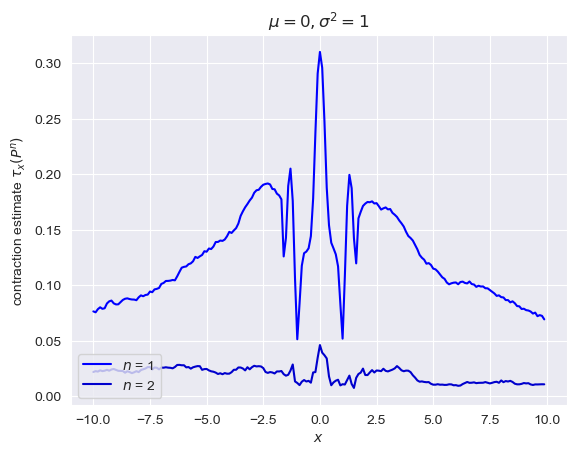

In [23]:
plt.title(r"$\mu=0, \sigma^2 = 1$")
plt.plot(x, taus1, color="blue", label=r"$n$ = 1")
plt.plot(x, taus2, color="mediumblue", label=r"$n$ = 2")
# plt.plot(x, taus5, color="mediumblue", label=r"$n$ = 5")
# plt.plot(x, taus10, color="darkblue", label=r"$n$ = 10")
# plt.plot(x, taus25, color="midnightblue", label=r"$n$ = 25")
# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="lower left")
# plt.savefig(svg_dir + "asss-univariate-x-contraction.svg", format="svg")

In [24]:
%%time

n = 1
rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

sample_fn = lambda rng_key, x, n_samples: kernel_sss_normal.sample_Pnx(rng_key, x, s1, n, n_samples)
tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_train_batches=10, n_eval_batches=100)

print(tau)

0.3159988
CPU times: user 13min 31s, sys: 13.6 s, total: 13min 44s
Wall time: 4min 30s


In [25]:
get_taus_n(rng_key, kernel_sss_normal, X, s1, n=1, n_samples=int(1e6), eps=0.1).max()

Array(0.31031612, dtype=float32)

In [26]:
f= lambda x: model.apply(params, x)
Pf = f(sample_fn(rng_key, X, n_samples=int(1e5))).mean(axis=-1)

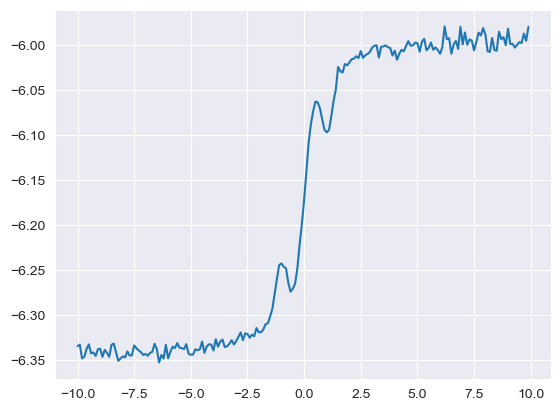

In [29]:
# plt.plot(x, f(X))
plt.plot(x, Pf)

In [67]:
def Pf(x, rng_key=random.PRNGKey(0), n_samples=1000, n_batches=10):
    rng_keys = random.split(rng_key, n_batches)
    
    def Pf_batch(r_key):
        samples = sample_fn(r_key, x, n_samples)
        return f(samples).mean()
    
    return vmap(Pf_batch)(rng_keys).mean(axis=0)         

In [13]:
rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

def get_max_taus(n_list, adapt_state, tau_samples=1000):
       
    rng_keys = random.split(rng_key, tau_samples)
    
    def max_tau_fn(n):
        sample_fn = lambda rng_key: kernel.sample_Pnx(rng_key, X, adapt_state, n=n, n_samples=1000).mean(axis=1)
        Pnx = jax.lax.map(sample_fn, rng_keys, batch_size=100).mean(axis=0).squeeze()
        taus_n = jnp.abs((Pnx[2:] - Pnx[:-2])/(x[2:] - x[:-2]))
        
        return taus_n.max()
    
    return [max_tau_fn(n) for n in n_list]
    
    # def max_taus_n(n):
    #     max_taus_n = jax.lax.map(lambda key: max_tau_fn(key, n), rng_keys, batch_size=10)
    # 
    #     max_taus_mean = max_taus_n.mean(axis=0)
    # 
    #     max_taus_ci_lower = jnp.quantile(max_taus_n, (1-ci)/2, axis=0)
    #     max_taus_ci_upper = jnp.quantile(max_taus_n, (1+ci)/2, axis=0)
    # 
    #     return jnp.stack([max_taus_mean, max_taus_ci_lower, max_taus_ci_upper], axis=0)
    # 
    # 
    # max_taus_mean, max_taus_ci_lower, max_taus_ci_upper = vmap(max_taus_n, out_axes=1)(n_vals) 

    # max_taus = vmap(
    #         vmap(max_tau_fn, in_axes=(None, 0), out_axes=0),  # Apply over r_keys
    #         in_axes=(0, None), out_axes=0  # Apply over n
    #     )(rng_keys, n_vals)
    # 
    # max_taus_mean = max_taus.mean(axis=0)
    # 
    # max_taus_ci_lower = jnp.quantile(max_taus, (1-ci)/2, axis=0)
    # max_taus_ci_upper = jnp.quantile(max_taus, (1+ci)/2, axis=0)

    # return max_taus_mean, max_taus_ci_lower, max_taus_ci_upper

In [73]:
%%time
n_list = [1, 5, 10, 15, 20, 25]

max_taus_s1 = get_max_taus(n_list, s1)
max_taus_s2 = get_max_taus(n_list, s2)
max_taus_s3 = get_max_taus(n_list, s3)

print("Computed")

KeyboardInterrupt: 

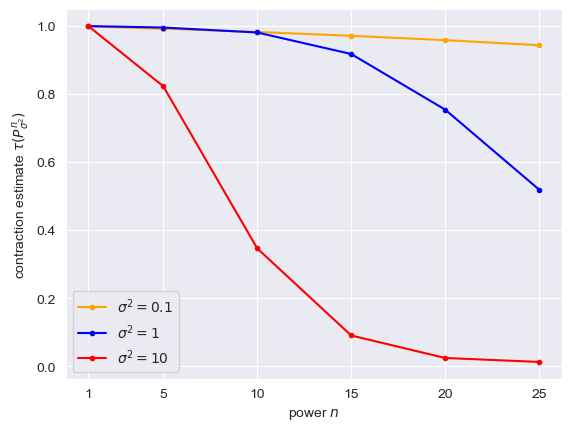

In [103]:
fig, ax1 = plt.subplots(1, 1)
# plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(n_list, max_taus_s2, ".-", color='orange', label=r"$\sigma^2 = 0.1$")
# ax1.fill_between(n_list, max_taus_ci_lower_s2, max_taus_ci_upper_s2, alpha=0.3, color="orange", label="90% CI")

ax1.plot(n_list, max_taus_s1, ".-", color='blue', label=r"$\sigma^2 = 1$")
# ax1.fill_between(n_list, max_taus_ci_lower_s1, max_taus_ci_upper_s1, alpha=0.3, color="blue", label="90% CI")

ax1.plot(n_list, max_taus_s3, ".-", color='red', label=r"$\sigma^2 = 10$")
# ax1.fill_between(n_list, max_taus_ci_lower_s3, max_taus_ci_upper_s3, alpha=0.3, color="red", label="90% CI")

ax1.set_ylabel(r"contraction estimate $ \tau(P_{\sigma^2}^n)$")

ax1.set_xticks(n_list)
# ax1.set_yticks([0.1, 0.5, 1])
# ax1.semilogy()


ax1.set_xlabel("power $n$")
ax1.legend(loc="lower left")
# plt.savefig(svg_dir + "univariate-contraction-decrease.svg", format="svg")

In [12]:
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

N = 10000

rng_key = random.PRNGKey(0)

In [12]:
x_vals, taus = get_taus_n(rng_key, kernel, X, s1, n=50, n_samples=N)

In [34]:
from metrics import compute_wasserstein_contraction

rng_key = random.PRNGKey(0)

X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

def get_max_taus_dual(n_list, adapt_state, tau_samples=100, ci=0.9):
    rng_keys = random.split(rng_key, tau_samples)
    n_vals = jnp.array(n_list)

    @jit
    def taus_dual_fn(rng_key, n):
        sample_fn = lambda rng_key, x, n_samples: kernel.sample_Pnx(rng_key, x, adapt_state, n, n_samples)
        tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_eval_batches=100)
        return tau

    def max_taus_n(n):
        # max_taus_n = jax.lax.map(lambda key: taus_dual_fn(key, n), rng_keys)
        max_taus_n = vmap(taus_dual_fn, in_axes=(0, None))(rng_keys, n)

        max_taus_mean = max_taus_n.mean(axis=0)

        max_taus_ci_lower = jnp.quantile(max_taus_n, (1-ci)/2, axis=0)
        max_taus_ci_upper = jnp.quantile(max_taus_n, (1+ci)/2, axis=0)

        return jnp.stack([max_taus_mean, max_taus_ci_lower, max_taus_ci_upper], axis=0)


    taus_mean, taus_ci_lower, taus_ci_upper = jnp.stack([max_taus_n(n) for n in n_list], axis=1)

    # taus_mean, taus_ci_lower, taus_ci_upper = vmap(max_taus_n, out_axes=1)(n_vals)  

    # max_taus_dual = vmap(
    #     vmap(taus_dual_fn, in_axes=(None, 0), out_axes=0),  # Apply over rng_keys
    #     in_axes=(0, None), out_axes=0  # Apply over n_vals
    # )(rng_keys, n_vals)
    # 
    # taus_mean = max_taus_dual.mean(axis=0)
    # 
    # taus_ci_lower = jnp.quantile(max_taus_dual, (1-ci)/2, axis=0)
    # taus_ci_upper = jnp.quantile(max_taus_dual, (1+ci)/2, axis=0)

    return taus_mean, taus_ci_lower, taus_ci_upper

In [59]:
%%time

max_taus_dual_s1, max_taus_dual_ci_lower_s1, max_taus_dual_ci_upper_s1  = get_max_taus_dual([25], s1, tau_samples=20)

print(max_taus_dual_s1)

[0.5181394]
CPU times: user 23min 26s, sys: 40.8 s, total: 24min 7s
Wall time: 8min 37s


## 1.5 Kernel distance

In [25]:
rng_key = random.PRNGKey(0)

mcmc = infer.MCMC(kernel_nuts_normal, num_warmup=0, num_samples=10000)
mcmc.run(rng_key, extra_fields=("adapt_state",), init_params=jnp.array([0.0]))

TypeError: Gradient only defined for scalar-output functions. Output had shape: (1,).

In [46]:
adapt_states = mcmc.get_extra_fields()["adapt_state"]
# mean, cov, lam = adapt_states

In [46]:
proposal_cov = jnp.expand_dims(jnp.exp(lam), [1,2]) * cov

In [48]:
from ARWMH import state_dist

In [53]:
idx1 = 100 
s1 = ARWMHAdaptState(mean[idx1], cov[idx1], lam[idx1])

In [54]:
s1

AMHAdaptState(mean=Array([0.03975414], dtype=float32), covariance=Array([[1.2438252]], dtype=float32), log_step_size=Array(1.4834536, dtype=float32))

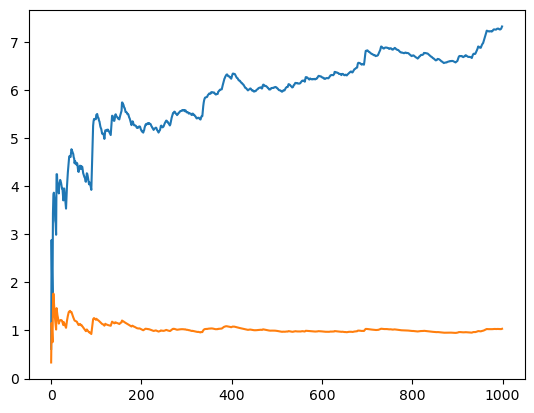

In [47]:
plt.plot(proposal_cov.squeeze())
plt.plot(cov.squeeze())

In [10]:

sample_P = lambda rng_key, x, n_samples: sample_Pnx(rng_key, kernel, x, s1, 1, n_samples)
sample_Q = lambda rng_key, x, n_samples: sample_Pnx(rng_key, kernel, x, s2, 1, n_samples)

rng_key = random.PRNGKey(0)
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)

In [11]:
rho, f = compute_kernel_distance(sample_P, sample_Q, rng_key, X, n_samples=5000, steps=200)

Step 0, Loss: -0.6671554446220398, Grad norm: 0.0005533649818971753
Step 10, Loss: -0.7025560736656189, Grad norm: 0.006827943027019501
Step 20, Loss: -0.7053455710411072, Grad norm: 0.006397875491529703
Step 30, Loss: -0.7057971358299255, Grad norm: 0.006377199664711952
Step 40, Loss: -0.7070958614349365, Grad norm: 0.007317858748137951
Step 50, Loss: -0.7041546702384949, Grad norm: 0.005662539973855019
Step 60, Loss: -0.7071062922477722, Grad norm: 0.006836296524852514
Step 70, Loss: -0.7051123380661011, Grad norm: 0.00584377720952034
Step 80, Loss: -0.7048067450523376, Grad norm: 0.00602379348129034
Step 90, Loss: -0.7059532999992371, Grad norm: 0.006388838402926922
Step 100, Loss: -0.7064651846885681, Grad norm: 0.006562430877238512
Step 110, Loss: -0.7040368914604187, Grad norm: 0.0057345847599208355
Step 120, Loss: -0.705633282661438, Grad norm: 0.006236946675926447
Step 130, Loss: -0.7060680389404297, Grad norm: 0.0062217810191214085
Step 140, Loss: -0.7073402404785156, Grad nor

In [12]:
rho

Array(0.19459969, dtype=float32)

In [18]:
X = jnp.arange(-10, 10, 0.01).reshape(-1, 1)
x = X.squeeze()

func = lambda x: f(x.reshape(-1, 1))
# fx = vmap(func)(x)

Px = sample_P(rng_key, X, n_samples=10000)
Qx = sample_Q(rng_key, X, n_samples=10000)

Pfx = vmap(func)(Px).mean(axis=1)
Qfx = vmap(func)(Qx).mean(axis=1)

diff = Pfx - Qfx

# 2. Gaussian Mixture

In [7]:
mixing_dist = dist.Categorical(probs=jnp.array([1/2, 1/2]))
component_dist = dist.Normal(loc=jnp.array([-1, 1]), scale=jnp.array([.1, .1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

In [8]:
kernel_rwm_mixture = ARWMH(potential_fn=potential_fn)
kernel_sss_mixture = ASSS(potential_fn=potential_fn)

In [9]:
N = 100000
mixture_samples = mixture.sample(random.PRNGKey(0), (N,))
jnp.std(mixture_samples)

Array(1.0046641, dtype=float32)

Text(0.5, 0, '$x$')

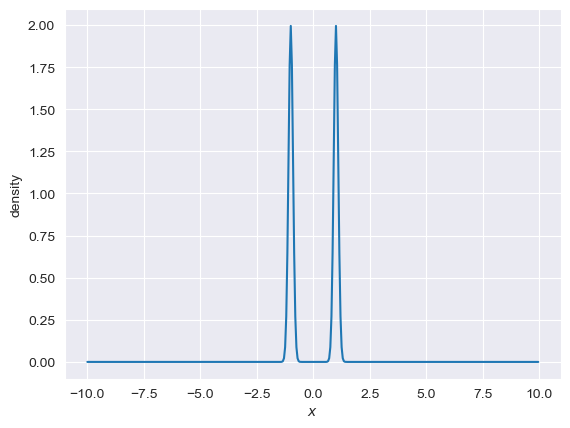

In [10]:
x= jnp.arange(-10, 10, 0.05)
plt.plot(x, jnp.exp(mixture.log_prob(x)))
plt.ylabel("density")
plt.xlabel("$x$")
# plt.legend()
# plt.savefig(svg_dir + "mixture-density", format="svg")


## 1.2. Sampling from $P(x, \cdot)$

In [11]:
rng_key = random.PRNGKey(0)
X = jnp.arange(-10, 10, 0.1).reshape(-1, 1)
x = X.squeeze()

In [12]:
%%time 

N = 100000

P1x = kernel_sss_mixture.sample_Pnx(rng_key, X, s1, n=2, n_samples=N).squeeze()
# P2x = kernel.sample_Pnx(rng_key, kernel, X, s2, N).squeeze()
print(P1x.mean())

KeyboardInterrupt: 

In [13]:
P1x_mean = P1x.mean(axis=1) 
P1x_lower = jnp.quantile(P1x, 0.05, axis=1)
P1x_upper = jnp.quantile(P1x, 0.95, axis=1)

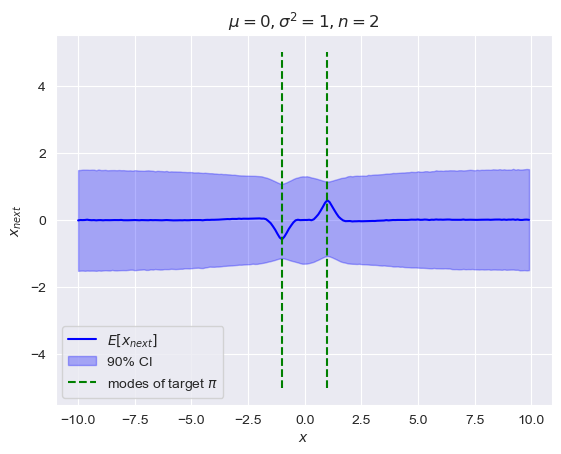

In [16]:
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\mu=0, \sigma^2=1, n=2$")

ax1.plot(x, P1x_mean, color='blue', label="$E[x_{next}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
# ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
# ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = 0$")
ax1.vlines([-1, 1], -5, 5, linestyles='--', color="green", label=r"modes of target $\pi$")
ax1.set_ylabel("$x_{next}$")
ax1.set_xlabel("$x$")
ax1.legend(loc="lower left")

# plt.savefig(svg_dir + "asss-mixture-x-step-cov1-n2.svg", format="svg")

In [112]:
x = X.squeeze()
dP1x = P1x - X

dP1x_mean = dP1x.mean(axis=1) 
dP1x_acc_mean = dP1x.mean(axis=1, where=(dP1x != 0.0)) 
P1x_lower = jnp.quantile(dP1x, 0.05, axis=1)
P1x_upper = jnp.quantile(dP1x, 0.95, axis=1)

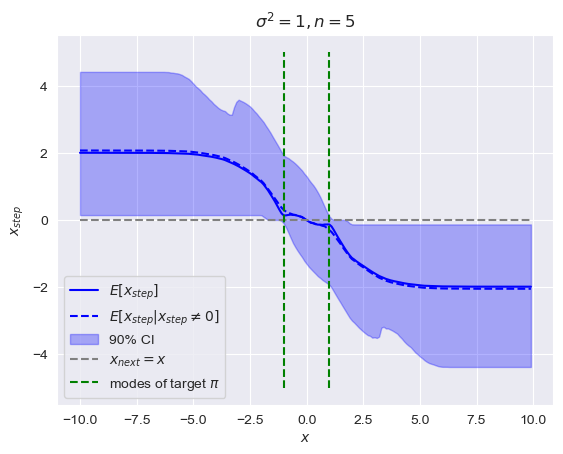

In [113]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(11,5))
fig, ax1 = plt.subplots(1,1)
plt.title(r"$\sigma^2=1, n=5$")

ax1.plot(x, dP1x_mean, color='blue', label="$E[x_{step}]$")
# ax2.plot(x, dP2x_mean, color='orange', label="$E[x_{step}]$ for $P_2$")
ax1.plot(x, dP1x_acc_mean, linestyle="--", color='blue', label=r"$E[x_{step} | x_{step} \ne 0]$")
# ax2.plot(x, dP2x_acc_mean, color='orange', linestyle='--', label=r"$E[x_{step} | x_{step} \ne 0]$ for $P_2$")
ax1.fill_between(x, P1x_lower, P1x_upper, alpha=0.3, color="blue", label="90% CI")
# ax2.fill_between(x, P2x_lower, P2x_upper, alpha=0.3, color="orange", label="90% CI")
# ax1.plot(x, x, '--', color="gray", label="x=x_next")
# ax2.plot(x, x, '--', color="gray", label="x=x_next")
ax1.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
# ax2.hlines(0, x[0], x[-1], linestyles='--', color="gray", label="$x_{next} = x$")
ax1.vlines([-1, 1], -5, 5, linestyles='--', color="green", label=r"modes of target $\pi$")
# ax2.vlines(0, -5, 5, linestyles='--', color="green", label=r"mode of target $\pi$")
ax1.set_ylabel("$x_{step}$")
ax1.set_xlabel("$x$")
# ax2.set_xlabel("$x$")
ax1.legend(loc="lower left")
# ax2.legend(loc="lower left")

# plt.savefig(svg_dir + "mixture-x-step-cov1-n5.svg", format="svg")

## 1.3. Invariance Property

In [17]:
%%time

k1, k2, ks = random.split(random.PRNGKey(0), 3)
dist_samples = mixture.sample(ks, sample_shape=(100000,1))

P1pi = kernel_sss_mixture.sample_Pnx(k1, dist_samples, s1, n_samples=1).flatten()
# P2pi = sample_Px(k2, kernel, dist_samples, s2, n_samples=1).flatten()

CPU times: user 1.09 s, sys: 48 ms, total: 1.14 s
Wall time: 573 ms


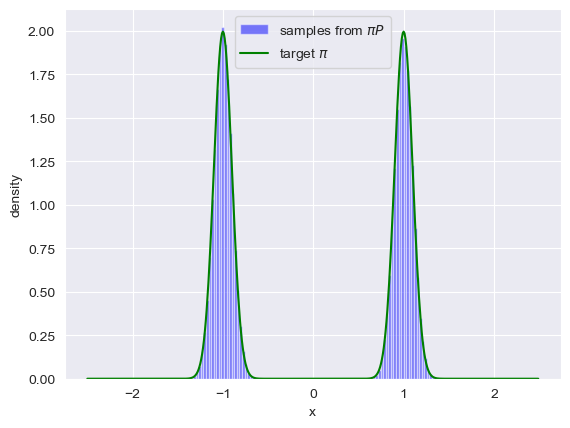

In [21]:
x = jnp.arange(-2.5, 2.5, 0.01)

plt.hist(P1pi, bins=100, density=True, alpha=0.5, color="blue", label=r"samples from $\pi P$")
# plt.hist(dist_samples, bins=100, density=True, alpha=0.5, color="green", label=r"samples from $\pi$")

# plt.hist(P2pi, bins=50, density=True, alpha=0.5, label=r"samples from $\pi P_2$")
plt.plot(x, jnp.exp(mixture.log_prob(x)), color="green", label=r"target $\pi$")
plt.xlabel("x")
plt.ylabel("density")
plt.legend(loc="upper center")
plt.savefig(svg_dir + "asss-mixture-invariance.svg", format="svg")

## 1.4. Contraction Property

In [26]:
rng_key = random.PRNGKey(0)

x = jnp.arange(-2.5, 2.5, 0.05)
X = x.reshape(-1, 1)

N = 1000000

taus1 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=1, n_samples=N, eps=1e-2)
taus2 = get_taus_n(rng_key, kernel_sss_normal, X, s1, n=2, n_samples=N, eps=1e-2)
# x_vals5, taus5 = get_taus_n(rng_key, kernel, X, s1, n=5, tau_samples=N)
# x_vals10, taus10 = get_taus_n(rng_key, kernel, X, s1, n=10, tau_samples=N)
# x_vals25, taus25 = get_taus_n(rng_key, kernel, X, s1, n=25, tau_samples=N)
print(taus2.max())

0.20563933


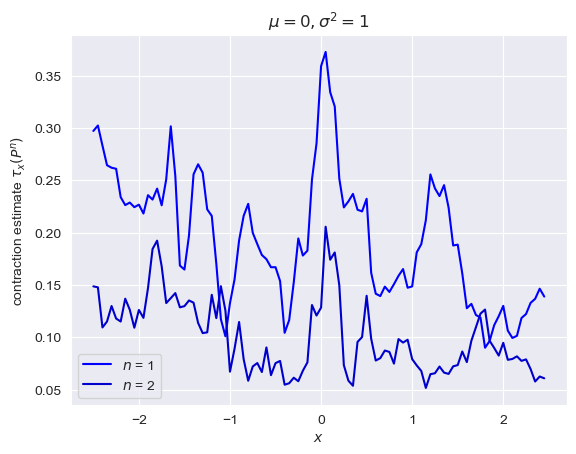

In [27]:
plt.title(r"$\mu=0, \sigma^2=1$")
plt.plot(x, taus1, color="blue", label=r"$n$ = 1")
plt.plot(x, taus2, color="mediumblue", label=r"$n$ = 2")
# plt.plot(x_vals5, taus5, color="mediumblue", label=r"$n$ = 5")
# plt.plot(x_vals10, taus10, color="darkblue", label=r"$n$ = 10")
# plt.plot(x, taus25, color="midnightblue", label=r"$n$ = 25")
# plt.semilogy()
plt.xlabel("$x$")
plt.ylabel(r"contraction estimate $\tau_x(P^n)$")
plt.legend(loc="lower left")
# plt.savefig(svg_dir + "asss-mixture-x-contraction.svg", format="svg")

In [ ]:
%%time

n = 1
rng_key = random.PRNGKey(0)

x = jnp.arange(-2.5, 2.5, 0.05)
X = x.reshape(-1, 1)

sample_fn = lambda rng_key, x, n_samples: kernel_sss_mixture.sample_Pnx(rng_key, x, s1, n, n_samples)
tau, model, params = compute_wasserstein_contraction(sample_fn, rng_key, X, n_train_batches=10, n_eval_batches=100)

print(tau)

In [ ]:
f= lambda x: model.apply(params, x)

f_mean = f(mixture.sample(rng_key, sample_shape=(100000,1))).mean()

Pf = f(sample_fn(rng_key, X, n_samples=int(1e6))).mean(axis=-1)
Pf -= f_mean

plt.plot(x, Pf)
plt.plot(x[1:-1], (Pf[:-2] - Pf[2:]) / (x[:-2] - x[2:]))

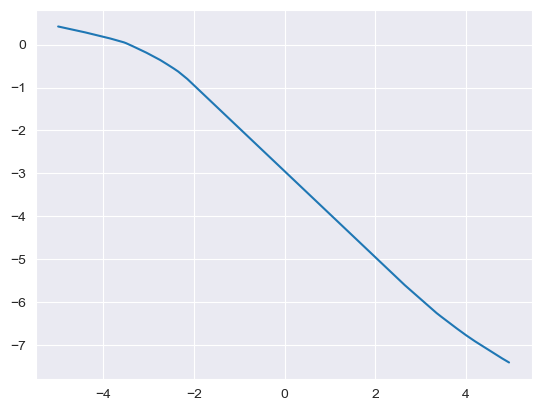

In [15]:
plt.plot(x, f(X))

# Lipschitz Property

In [ ]:
def sample_lipschitz_func(rng_key, domain=(-10, 10), step=0.1):
    """
    Generates a random 1-Lipschitz finction with given domain and grid size
    """
    points = jnp.arange(*domain, step)
    N, = points.shape

    u = dist.Uniform(-1, 1).sample(rng_key, sample_shape=(N,))
    u -= u.mean()
    u /= jnp.max(jnp.abs(u))
    
    values = jnp.tri(N,N) @ u * step
        
    return jax.scipy.interpolate.RegularGridInterpolator((points,), values, fill_value=0)

In [ ]:
# func = sample_lipschitz_func(random.PRNGKey(0), domain=(-10, 10), step=0.1)
func = lambda x: f(x.reshape(-1, 1))

P1fx = vmap(func)(P1x).mean(axis=0)
P2fx = vmap(func)(P2x).mean(axis=0)

jnp.abs(jnp.diff(func(x))/jnp.diff(x)).max()

In [ ]:
plt.plot(x, func(x), label="f(x)")
plt.plot(x, P1fx, label="P1f(x)")
plt.plot(x, P2fx, label="P2f(x)")
# plt.plot(x, jnp.abs(P1fx-P2fx), label="diff")
plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
plt.xlabel("x")
plt.legend()

In [ ]:
diff = P1fx - P2fx

diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()
diff_norm

In [ ]:
def compute_lipschitz(rng_key, kernel, eps=0.001, domain=(-10, 10), step=0.01, n_samples=500):

    x = jnp.arange(*domain, step)
    key_func, rng_key = random.split(rng_key)
    func = sample_lipschitz_func(key_func, domain, 10*step)
    
    key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)
    
    s1 = sample_adapt_state(key_state1)
    s2 = sample_neigbour(key_state2, s1, eps)
    
    P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=n_samples)
    P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=n_samples)
    
    P1fx = vmap(func)(P1x).mean(axis=0)
    P2fx = vmap(func)(P2x).mean(axis=0)
    
    diff = P1fx - P2fx

    diff_norm = jnp.abs(jnp.diff(diff)/jnp.diff(x)).max()

    return diff_norm, state_dist(s1, s2)

In [ ]:
# %%time
# 
# rng_key = random.split(random.PRNGKey(0), 10)
# 
# diff_norm, states_dist = vmap(lambda key: compute_lipschitz(key, kernel))(rng_key)

In [ ]:
# plt.scatter(states_dist, diff_norm)
# plt.ylabel("diff_norm")
# plt.xlabel("states_dist")
# plt.semilogx()
# plt.semilogy()

In [ ]:
with open("lipschitz.pkl", "rb") as f:
    d = pickle.load(f)

L = jnp.max(d["diff_norm"] / d["states_dist"])
L

In [ ]:
rng_key = d["rng_key"][jnp.argmax(d["diff_norm"] / d["states_dist"])]

eps=0.001
domain=(-10, 10)
# step=0.01
n_samples=500

x = jnp.arange(*domain, 0.005)
key_func, rng_key = random.split(rng_key)
func = sample_lipschitz_func(key_func, domain, step=0.1)

key_state1, key_state2, key_kernel1, key_kernel2 = random.split(rng_key, 4)

s1 = sample_adapt_state(key_state1)
s2 = sample_neigbour(key_state2, s1, eps)

P1x = sample_Px(key_kernel1, kernel, x, s1, n_samples=n_samples)
P2x = sample_Px(key_kernel2, kernel, x, s2, n_samples=n_samples)

P1fx = vmap(func)(P1x).mean(axis=0)
P2fx = vmap(func)(P2x).mean(axis=0)

diff = P1fx - P2fx

print("L-norm: " , jnp.abs(jnp.diff(diff)/jnp.diff(x)).max().item())
print("sup-norm: " , jnp.abs(diff).max().item())


In [ ]:
plt.plot(x, func(x), label="f(x)")
plt.plot(x, P1fx, label="P1f(x)")
plt.plot(x, P2fx, label="P2f(x)")
plt.plot(x, diff, label="diff")
plt.hlines(func(dist_samples).mean(), x.min(), x.max(), linestyles="--", color="gray", label="pi(f)")
plt.xlabel("x")
plt.legend()

In [ ]:
plt.scatter(d["states_dist"], d["diff_norm"], label="experiments")

dists = jnp.logspace(jnp.log10(d["states_dist"].min()) -1, jnp.log10(d["states_dist"].max()))
plt.plot(dists, L*dists, "--", color="gray", label="bound")

plt.ylabel("diff_norm")
plt.xlabel("states_dist")
plt.semilogx()
plt.semilogy()
plt.ylim(0.1*jnp.min(d["diff_norm"][d["diff_norm"] > 0]), 10 * jnp.max(d["diff_norm"]))
plt.legend()

# 2. Gaussian Mixture

In [ ]:
mixing_dist = dist.Categorical(probs=jnp.array([1/3, 2/3]))
component_dist = dist.Normal(loc=jnp.array([-5, 5]), scale=jnp.array([1, 1]))
mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

potential_fn = lambda x: -1 *mixture.log_prob(x)

# 3. Posteriordb

In [ ]:
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

In [ ]:
posterior = my_pdb.posterior("kidiq-kidscore_momhsiq")

p_model = posterior.model
p_data = posterior.data

In [ ]:
data = {key: jnp.array(val) for key, val in posterior.data.values().items() if type(val) is list}
data_rest = {key: val for key, val in posterior.data.values().items() if type(val) is not list}

In [ ]:
reference_draws_df = pd.concat([
    pd.DataFrame(chain_draw).assign(chain_id=i)
    for i, chain_draw in enumerate(posterior.reference_draws())
])
reference_draws_df.drop(columns=["chain_id"], inplace=True)

reference_draws = jnp.asarray(reference_draws_df)

In [ ]:
sns.pairplot(reference_draws_df)

In [ ]:
def model(mom_iq, mom_hs, kid_score=None):

    # Priors
    beta = numpyro.sample("beta", dist.ImproperUniform(dist.constraints.real_vector, (), event_shape=(3,)))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2.5))

    
    # Linear model
    ones = jnp.ones_like(mom_hs)
    X = jnp.stack([ones, mom_hs, mom_iq], axis=1)
    mu = jnp.matmul(X, beta)
    # mu = beta[0] + beta[1] * mom_hs + beta[2] * mom_iq

    # Observed variable
    numpyro.sample("kid_score_obs", dist.Normal(mu, sigma), obs=kid_score)

render_model(model, model_kwargs=data, render_distributions=True)

In [ ]:
kernel = ARWMH(model)
rng_key = random.PRNGKey(0)

state = kernel.init(rng_key, num_warmup=0, init_params={}, model_args=(), model_kwargs=data)

In [ ]:
s1 = sample_adapt_state(rng_key, dim=len(state.adapt_state.mean))
s2 = sample_neigbour(rng_key, state.adapt_state)

In [ ]:
from jax.flatten_util import ravel_pytree

z_flat, unravel_fn = ravel_pytree(state.z)

In [ ]:
state

In [ ]:
kernel._postprocess_fn()

In [ ]:
state_ = ARWMHState(
    i=0,
    z=unravel_fn(z_flat),
    potential_energy=
)

In [ ]:
reference_draws_df